# Анализ данных интернет-магазина товаров для дома «Пока все ещё тут»

В нашем распоряжении данные интернет-магазина «Пока все ещё тут», который продаёт товары для дома и быта. 
Нам доступны данные о датах заказов, индификатор пользователей и заказов, наименование товара, количество товара в заказе и цена товара. 
Цель проекта - сегментировать покупателей по профилю потребления для создания персонализированных предложений. 

Наша работа будет состоять из 6 шагов:

1. Загрузка данных
2. Предобработка данных (исследовать пропущенные значения, дубликаты, типы данных, наименование колонок, проверка на бизнес-правила "1 заказ - 1 клиент" и "1 заказ" - "1 дата")
3. Исследовательский анализ данных (добавление необходимых столбцов: общее количество заказов у клиента, средний чек клиента, сумма общих покупок клиента, сумма текущего заказа)
4. Сегментирование покупателей по профилю потребления (с исспользованием RFM-анализа, для этого используем 3 метрики: давность заказа, частота покупок и сумма покупок)
5. Формулировка и проверка статистических гипотез:
  - Гипотеза о различии среднего чека в группах 
  - Гипотеза о различии количества заказов в группах 
6. Презентация и итоговый вывод

В итоге работы мы получим информацию о том, на какие группы мы можем разделить покупателей для внедрения персонализированных предложений. Также мы подтвердим или опровергнем наши гипотезы.

## Загрузка данных и импорт необходимых библиотек.

In [1]:
#Аналитика
import pandas as pd
import numpy as np 
import datetime as dt
from datetime import datetime, timedelta
import math
import scipy.stats as stats
from scipy import stats as st

#Визуализация 
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.graph_objs import Scatter, Figure, Layout
import plotly
import plotly.graph_objs as go
import plotly.express as px

# для игнорирования предупреждений
import warnings
warnings.filterwarnings('ignore')

# увеличим количество символов, которые можно показывать
pd.options.display.max_colwidth = 150
# выставляем ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.3f}'.format

In [2]:
#Откроем файлы.
try:
    data = pd.read_csv('/datasets/ecom_dataset_upd.csv')
except:
    data = pd.read_csv('ecom_dataset_upd.csv')

## Предобработка данных.

In [3]:
data.head(5)

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.000
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.000
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.000
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.000
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


In [5]:
#Проверим на наличие пропусков и дубликатов 
display(data.duplicated().sum())
data.isna().sum()

0

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

Всего у нас 6 столбов и 7474 строк, дубликатов и пропусков в данных не обнаружено. Наименования колонок соответстует требованиям.  
Нужно привести данные в столбце date к типу даты pandas.

In [6]:
# Приведем данные в столбце date к типу даты pandas
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H')

Проверим на неявные дубликаты в данных по бизнес-правилам "1 заказ - 1 клиент" и "1 заказ" - "1 дата"

In [7]:
# Проверка на бизнес-правило "1 заказ - 1 клиент"
dublicates_order = data.groupby('order_id').agg({'customer_id':'nunique'}).query('customer_id > 1')
display(dublicates_order.head(5))
print('Количество уникальных заказов с различными клиентскими id:', dublicates_order.shape[0])

,customer_id
order_id,
14872,2
68785,2
69283,2
69310,2
69345,2


Количество уникальных заказов с различными клиентскими id: 29


Всего у нас нашлось 29 уникальных заказов с различными клиентскими id. Скорее всего это ошибка была допущена во время загрузки данных на сервер. Так как таких заказов не сильно много, удалим их из итогового датафрейма.   

In [8]:
#Образуем лист повторяющихся id заказов 
list_of_order_id = dublicates_order.index.tolist()
#Удалим данные заказы из итогового датафрейма
data = data.query('order_id not in @list_of_order_id')

In [9]:
# Проверка на бизнес-правила "1 заказ" - "1 дата"
dublicates_date = data.groupby('order_id').agg({'date':'nunique'}).query('date > 1')
display(dublicates_date.head(5))
print('Количество уникальных заказов с различными датами:', dublicates_date.shape[0])

,date
order_id,
13547,7
14500,4
14504,2
14505,2
14521,6


Количество уникальных заказов с различными датами: 256


Всего мы нашли 256 уникальных заказов с разными датами. Рассмотрим один из таких заказов более детально. 

In [10]:
data[data['order_id'] == 14521]

,date,customer_id,order_id,product,quantity,price
1471,2019-01-10 17:00:00,4d416cec-6f5b-4444-9b50-08770397714b,14521,Пеларгония зональная диам. 12 см белая полумахровая,1,188.000
1472,2019-01-10 17:00:00,4d416cec-6f5b-4444-9b50-08770397714b,14521,Пеларгония зональная диам. 12 см красная махровая,1,188.000
1473,2019-01-10 17:00:00,4d416cec-6f5b-4444-9b50-08770397714b,14521,Пеларгония зональная диам. 12 см темнорозовая полумахровая,1,188.000
1475,2019-01-10 18:00:00,4d416cec-6f5b-4444-9b50-08770397714b,14521,Пеларгония зональная диам. 12 см белая полумахровая,1,188.000
1476,2019-01-10 18:00:00,4d416cec-6f5b-4444-9b50-08770397714b,14521,Пеларгония зональная диам. 12 см красная махровая,1,188.000
1477,2019-01-10 18:00:00,4d416cec-6f5b-4444-9b50-08770397714b,14521,Пеларгония зональная диам. 12 см темнорозовая полумахровая,1,188.000
1500,2019-01-13 11:00:00,4d416cec-6f5b-4444-9b50-08770397714b,14521,Пеларгония зональная диам. 12 см белая полумахровая,1,188.000
1501,2019-01-13 11:00:00,4d416cec-6f5b-4444-9b50-08770397714b,14521,Пеларгония зональная диам. 12 см красная махровая,1,188.000
1502,2019-01-13 11:00:00,4d416cec-6f5b-4444-9b50-08770397714b,14521,Пеларгония зональная диам. 12 см темнорозовая полумахровая,1,188.000
1547,2019-01-19 10:00:00,4d416cec-6f5b-4444-9b50-08770397714b,14521,Пеларгония зональная диам. 12 см белая полумахровая,1,188.000


Как мы видим, у нас несколько раз дублируются заказы с одиннаковым набором товаров, но разной датой. Скорее всего была свершена ошибка также при переносе данных на сервер и данные по заказам задвоились. Оставим данные о заказе с последней известной датой. 

In [11]:
data = data.drop_duplicates(subset=['order_id', 'product'], keep='last')

In [12]:
data[data['order_id'] == 14521]

,date,customer_id,order_id,product,quantity,price
1639,2019-01-30 20:00:00,4d416cec-6f5b-4444-9b50-08770397714b,14521,Пеларгония зональная диам. 12 см белая полумахровая,1,188.000
1640,2019-01-30 20:00:00,4d416cec-6f5b-4444-9b50-08770397714b,14521,Пеларгония зональная диам. 12 см красная махровая,1,188.000
1641,2019-01-30 20:00:00,4d416cec-6f5b-4444-9b50-08770397714b,14521,Пеларгония зональная диам. 12 см темнорозовая полумахровая,1,188.000


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5522 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5522 non-null   datetime64[ns]
 1   customer_id  5522 non-null   object        
 2   order_id     5522 non-null   int64         
 3   product      5522 non-null   object        
 4   quantity     5522 non-null   int64         
 5   price        5522 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 302.0+ KB


На нашем примере мы убедились что остались только нужные нам данные, без повторений. По итогу предобработки данным мы привели данные в столбце date к типу даты pandas, проверили данные на пропуски, явные и не явные дубликаты. С помощью бизнес-правил избавились от неявных дубликатов. В конечном итоге у нас 5522 строк с данными, которые готовы к исследовательскому анализу. 

## Исследовательский анализ данных.

Проанализируем за какой период у нас представлены данные. 

In [14]:
print('Первая дата в данных:', data['date'].min())
print('Последняя дата в данных:', data['date'].max())

Первая дата в данных: 2018-10-01 00:00:00
Последняя дата в данных: 2020-01-31 15:00:00


Таким образом, мы располагаем данными за 1 год и 4 месяца. 

In [15]:
#Добавим столбец с месяцом и днем покупки
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['weekday'] = data['date'].dt.weekday

In [16]:
#Подсчитаем уникальное количество заказов по дням
orders_per_date = data.groupby('day').agg({'order_id':'nunique'})

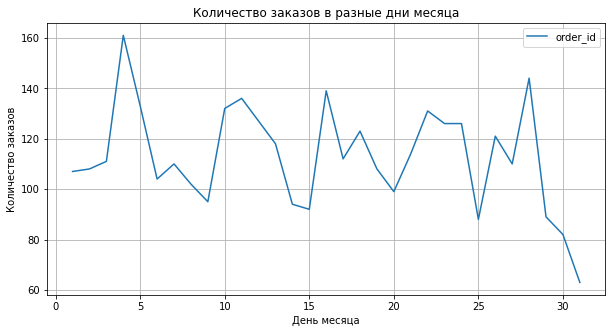

In [17]:
#Проанализируем влияют ли день на количество покупок 
orders_per_date.plot(grid=True, figsize=(10,5))
plt.title('Количество заказов в разные дни месяца')
plt.xlabel('День месяца')
plt.ylabel('Количество заказов')
plt.show()

Судя по графику пик активных заказов приходится на 4 число каждого месяца. В целом какой то сильной зависимости между днями месяца и количеством заказов нет. 

In [18]:
#Подсчитаем уникальное количество заказов по месяцам
orders_per_month = data.groupby('month').agg({'order_id':'nunique'})

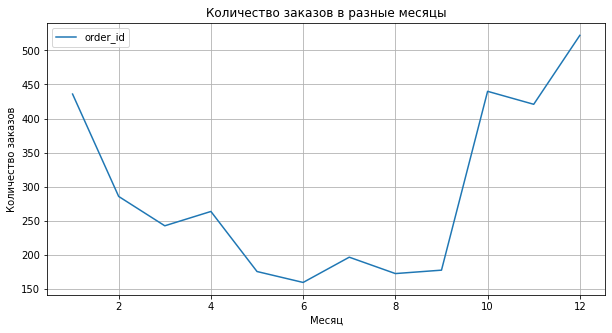

In [19]:
#Проанализируем влияют ли месяц на количество покупок 
orders_per_month.plot(grid=True, figsize=(10,5)) 
plt.title('Количество заказов в разные месяцы')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

Исследуя график количества заказов в разные месяцы, мы можем заметить явную зависимость продаж от сезона. С Сентября по февраль в интернет магазине больше всего заказов, потом идет резвий спад и минимальное число заказов. Это говорит нам о том, что количество заказов зависит от месяца.

In [20]:
#Подсчитаем уникальное количество заказов по месяцам
orders_per_weekday = data.groupby('weekday').agg({'order_id':'nunique'})

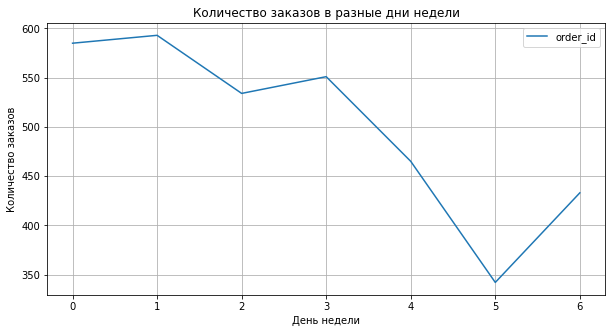

In [21]:
#Проанализируем влияют ли день недели на количество покупок 
orders_per_weekday.plot(grid=True, figsize=(10,5)) 
plt.title('Количество заказов в разные дни недели')
plt.xlabel('День недели')
plt.ylabel('Количество заказов')
plt.show()

Если рассматривать зависимость дня недели и количества заказов, то можно видеть, что на выходных снижается число заказов. В будни люди чаще заказывают товары для дома. 

Посчитаем основные метрики по данным и добавим необходимые столбцы.

In [22]:
#Посмотрим, сколько у нас в данных уникальных заказов и пользователей
print('Количество уникальных заказов за период:',data['order_id'].nunique())
print('Количество уникальных пользователей за период:',data['customer_id'].nunique())

Количество уникальных заказов за период: 3492
Количество уникальных пользователей за период: 2413


In [23]:
#Посчитаем сколько всего товаров было продано в интернет магазине за год и 4 месяца.
print('Количество проданного товара:',data['quantity'].sum())

Количество проданного товара: 14244


In [24]:
#Добавим столбец с ценой за количество товара в заказе
data['total'] = data['quantity'] * data['price']
#Посчитаем сумму всех проданных товаров
print('Сумма всех проданных товаров:',round(data['total'].sum(),2))

Сумма всех проданных товаров: 4593179.42


In [25]:
#Посчитаем сумму каждого заказа 
total_per_order = data.groupby('order_id').agg({'total':'sum'})

In [26]:
total_per_order

,total
order_id,
12624,375.000
13547,684.000
14480,359.000
14481,600.000
14482,376.000
...,...
112722,450.000
112732,90.000
112767,38.000


In [27]:
data[data['order_id'] == 112789]

,date,customer_id,order_id,product,quantity,price,month,day,weekday,total
7150,2019-12-26 22:00:00,65ed0726-5565-4c0e-905c-f9e9bd9f7642,112789,Сушилка для белья потолочно-настенная Gimi Lift 140,2,"1,349.000",12,26,3,"2,698.000"


In [28]:
#Найдем среднее, минимальное и максимальное значения по сумме заказа.  
total_per_order.describe()

,total
count,"3,492.000"
mean,"1,315.343"
std,"11,593.013"
min,9.000
25%,194.000
50%,581.000
75%,"1,267.250"
max,"675,000.000"


Минимальная выручка с заказа составляет 9 у.е., максимальная 675 000 у.е. В среднем выручка за заказ составляет 1 315.

In [29]:
#Посмотрим на самый дорогой заказ
total_per_order[total_per_order['total'] > 600000]

,total
order_id,
71743,"675,000.000"


In [30]:
data[data['order_id'] == 71743]

,date,customer_id,order_id,product,quantity,price,month,day,weekday,total
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Burstenmann, 0522/0000",1000,675.000,6,18,1,"675,000.000"


In [31]:
#Очень странно, что самый дорогой товар - это Вантуз с деревянной ручкой. 
#Удалим этот заказ, чтобы не портить статистику. 
data = data.drop([5456],axis = 0)
total_per_order = total_per_order.drop([71743],axis = 0)
total_per_order.describe()

,total
count,"3,491.000"
mean,"1,122.366"
std,"2,087.089"
min,9.000
25%,194.000
50%,580.000
75%,"1,257.333"
max,"49,432.000"


Теперь максимальная цена на заказ составляет 49 432, а средняя стоимость заказа равна 1122. 

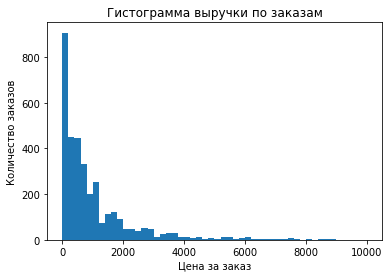

In [32]:
#Построим гистограмму для наглядности. 
plt.hist(total_per_order['total'], bins = 50, range = (0,10000))
plt.title('Гистограмма выручки по заказам')
plt.xlabel('Цена за заказ')
plt.ylabel('Количество заказов')
plt.show()

Судя по графику, выручка около 800 заказов составляет менее 300 у.е. В среднем большая часть заказов меньше 2 000 у. е. Скорее всего люди предпочитают заказывать дешевые товары в этом магазине. Крупные покупки делаются очень редко. 

In [33]:
data.columns.tolist()

['date',
 'customer_id',
 'order_id',
 'product',
 'quantity',
 'price',
 'month',
 'day',
 'weekday',
 'total']

In [34]:
#Присоеденим к основной таблице и переименуем столбцы
data = data.merge(total_per_order, how='outer', on='order_id')
data.columns = ['date',
 'customer_id',
 'order_id',
 'product',
 'quantity',
 'price',
 'month',
 'day',
 'weekday',               
 'total_price',
 'total_per_order']
data.head(5)

,date,customer_id,order_id,product,quantity,price,month,day,weekday,total_price,total_per_order
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.000,10,1,0,142.000,"1,037.000"
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.000,10,1,0,194.000,"1,037.000"
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.000,10,1,0,112.000,"1,037.000"
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.000,10,1,0,179.000,"1,037.000"
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.000,10,1,0,112.000,"1,037.000"


In [35]:
# Узнаем информацию о клиенте : сумма общих покупок, количество купленных товаров, количество заказов клиента
info_customer = data.groupby('customer_id').agg({'total_price':'sum', 'quantity':'sum', 'order_id':'nunique'})
info_customer.head(5)

,total_price,quantity,order_id
customer_id,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,555.000,4,1
001cee7f-0b29-4716-b202-0042213ab038,442.000,1,1
00299f34-5385-4d13-9aea-c80b81658e1b,914.000,2,1
002d4d3a-4a59-406b-86ec-c3314357e498,"1,649.000",1,1
003bbd39-0000-41ff-b7f9-2ddaec152037,"2,324.000",2,1


In [36]:
#Подсчитаем средний чек для каждого клиента
avg_per_customer = data.groupby(['customer_id', 'order_id']).agg({'total_per_order':'sum'})
avg_per_customer_1 = data.groupby('customer_id').agg({'total_per_order':'mean'})
avg_per_customer_1.head(5)

,total_per_order
customer_id,
000d6849-084e-4d9f-ac03-37174eaf60c4,555.000
001cee7f-0b29-4716-b202-0042213ab038,442.000
00299f34-5385-4d13-9aea-c80b81658e1b,914.000
002d4d3a-4a59-406b-86ec-c3314357e498,"1,649.000"
003bbd39-0000-41ff-b7f9-2ddaec152037,"2,324.000"


In [37]:
#Найдем среднее, минимальное и максимальное значения по среднему чеку клиентов. 
avg_per_customer_1.describe()

,total_per_order
count,"2,412.000"
mean,"1,174.388"
std,"2,109.306"
min,15.000
25%,300.000
50%,652.000
75%,"1,349.000"
max,"49,432.000"


Максимальный средний чек у пользователя был равен 49,432. В среднем значение среднего чека у клиентов равно 1,174. 

In [38]:
#Найдем среднее, минимальное и максимальное значения по суммарной выручки с клиента клиента.  
info_customer['total_price'].describe()

count     2,412.000
mean      1,624.452
std       4,341.389
min          15.000
25%         389.750
50%         834.000
75%       1,798.250
max     159,508.000
Name: total_price, dtype: float64

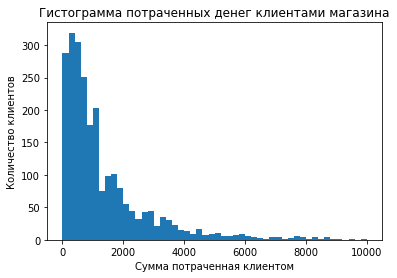

In [39]:
#Построим гистограмму для наглядности. 
plt.hist(info_customer['total_price'], bins = 50, range = (0,10000))
plt.title('Гистограмма потраченных денег клиентами магазина')
plt.xlabel('Сумма потраченная клиентом')
plt.ylabel('Количество клиентов')
plt.show()

В среднем клиенты магазина тратят 1 624, 75% покупателей приобрели товаров на сумму 1 798 за 1 год и 4 месяца. Больше всего потратил клиент, который сделал заказов на сумму 159 508. Скорее всего он сделал больше всего заказов. Далее в исследовании мы проверим это. 

In [40]:
info_customer[info_customer['total_price'] > 60000]

,total_price,quantity,order_id
customer_id,,,
c971fb21-d54c-4134-938f-16b62ee86d3b,"159,508.000",334,126


Данный клиент сделал 143 заказа на общую сумму 159 508. В среднем он заказывал на сумму 1 265 и купил 334 товара. 

In [41]:
#Найдем среднее, минимальное и максимальное значения по количеству товаров купленных клиентом. 
info_customer['quantity'].describe()

count   2,412.000
mean        5.491
std        18.075
min         1.000
25%         1.000
50%         2.000
75%         3.000
max       334.000
Name: quantity, dtype: float64

In [42]:
#Найдем среднее, минимальное и максимальное значения по количеству заказов клиента.
info_customer['order_id'].describe()

count   2,412.000
mean        1.447
std         2.699
min         1.000
25%         1.000
50%         1.000
75%         2.000
max       126.000
Name: order_id, dtype: float64

Клиент, который потратил больше всего денег, заказал больше всего заказов и купил больше всего товаров. 
В среднем клиенты делают около 1-2 заказов, 5-6 товаров покупают. 

In [43]:
#Присоеденим к основной таблице
data = data.merge(info_customer, how='outer', on='customer_id')
data = data.merge(avg_per_customer_1, how='outer', on='customer_id')
#Переименуем столбцы
data.columns = ['date',
 'customer_id',
 'order_id',
 'product',
 'quantity',
 'price',
 'month',
 'day',
 'weekday',                   
 'total_price',
 'total_per_order',
 'total_per_customer',
 'products_per_customer',             
 'orders_per_customer',
 'avg_customer_receipt']
data.head(5)

,date,customer_id,order_id,product,quantity,price,month,day,weekday,total_price,total_per_order,total_per_customer,products_per_customer,orders_per_customer,avg_customer_receipt
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.000,10,1,0,142.000,"1,037.000","1,037.000",7,1,"1,037.000"
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.000,10,1,0,194.000,"1,037.000","1,037.000",7,1,"1,037.000"
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.000,10,1,0,112.000,"1,037.000","1,037.000",7,1,"1,037.000"
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.000,10,1,0,179.000,"1,037.000","1,037.000",7,1,"1,037.000"
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.000,10,1,0,112.000,"1,037.000","1,037.000",7,1,"1,037.000"


Таким образом, средний клиент покупает 5-6 товаров на сумму 1122. За весь период делают 1-2 заказа. Средний чек клиентов состовляет 1,174 у. е. 

## Сегментирование покупателей по профилю потребления.

Для сегментирования покупателей с помощью RFM-анализа нам нужны такие параметры, как id клиента, id заказа, дата заказа, количество покупок и итоговая сумма покупок. 

In [44]:
#В датасете последний заказ был сделан 31 января 2020 года, 
# для расчета давности мы использовали его в качестве даты для функции NOW.
NOW = dt.datetime(2020,1,31)
# Создаём таблицу RFM
RFM_table = data.groupby('customer_id').agg({'date': lambda x: (NOW - x.max()).days, # Recency
                                                'order_id': lambda x: len(x.unique()), # Frequency
                                                'total_price': lambda x: x.sum()})    # Monetary 

RFM_table['date'] = RFM_table['date'].astype(int)

RFM_table.rename(columns={'date': 'recency', 
                         'order_id': 'frequency',
                         'total_price': 'monetary_value'}, inplace=True)
RFM_table.head(10)

,recency,frequency,monetary_value
customer_id,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,106,1,555.000
001cee7f-0b29-4716-b202-0042213ab038,348,1,442.000
00299f34-5385-4d13-9aea-c80b81658e1b,108,1,914.000
002d4d3a-4a59-406b-86ec-c3314357e498,368,1,"1,649.000"
003bbd39-0000-41ff-b7f9-2ddaec152037,123,1,"2,324.000"
004d24e9-4a6c-4d0e-8727-8391dfd4b43a,368,1,"1,536.000"
005ba170-45e8-42de-93f7-192481ae2659,86,2,"7,857.000"
00bd74b1-2792-47db-a2f1-680a09ac5026,466,1,937.000
00c0f92a-121a-4883-a78d-2c7b5fe187de,49,2,321.000


Теперь у нас есть значения RFM в отношении каждого пользователя. 

In [45]:
#Распределим на 3 квинтиля
quantiles = RFM_table.quantile(q=[0.33,0.66,0.99])
quantiles

,recency,frequency,monetary_value
0.330,102.000,1.000,524.000
0.660,297.260,2.000,"1,321.560"
0.990,481.890,3.000,"9,867.370"


In [46]:
# Конвентируем информацию о квинтилях в словарь
quantiles = quantiles.to_dict()
# Делаем копию таблицы RFM_table
RFM_Segment = RFM_table.copy()
# Присваеваем каждому  клиенту свою группу недавности 
def R_Class(x,p,d):
    if x <= d[p][0.33]:
        return 3
    elif x <= d[p][0.66]:
        return 2
    else:
        return 1
    
# Присваеваем каждому  клиенту свою группу частоты покупок и суммы покупок 
def FM_Class(x,p,d):
    if x <= d[p][0.33]:
        return 1
    elif x <= d[p][0.66]:
        return 2
    else:
        return 3
    
# Добовляем наши группы в итоговую таблицу 
RFM_Segment['R_Quartile'] = RFM_Segment['recency'].apply(R_Class, args=('recency',quantiles,))
RFM_Segment['F_Quartile'] = RFM_Segment['frequency'].apply(FM_Class, args=('frequency',quantiles,))
RFM_Segment['M_Quartile'] = RFM_Segment['monetary_value'].apply(FM_Class, args=('monetary_value',quantiles,))
# Считаем RFM показатель для каждого клиента
RFM_Segment['RFMClass'] = RFM_Segment.R_Quartile.map(str) \
                            + RFM_Segment.F_Quartile.map(str) \
                            + RFM_Segment.M_Quartile.map(str)

In [47]:
RFM_Segment.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_id,,,,,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,106,1,555.000,2,1,2,212
001cee7f-0b29-4716-b202-0042213ab038,348,1,442.000,1,1,1,111
00299f34-5385-4d13-9aea-c80b81658e1b,108,1,914.000,2,1,2,212
002d4d3a-4a59-406b-86ec-c3314357e498,368,1,"1,649.000",1,1,3,113
003bbd39-0000-41ff-b7f9-2ddaec152037,123,1,"2,324.000",2,1,3,213


Таким образом для каждого клиента мы присвоили значения:

По давности заказа (recency):
- 1 — давние клиенты;
- 2 — относительно недавние клиенты;
- 3 — недавние клиенты.

По частоте покупок (frequency):
- 1 — покупает очень редко (единичные заказы);
- 2 — покупает нечасто;
- 3 — покупает часто.

По сумме покупок (monetary):
- 1 — маленькая сумма;
- 2 — средняя сумма;
- 3 — большая сумма.

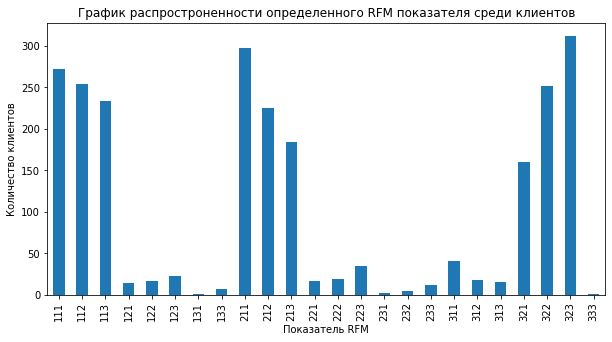

In [48]:
#Посмотрим показатель RFM среди пользователей на графике 
fig=plt.figure(figsize=(10, 5)), 
RFM_Segment.groupby('RFMClass').agg('recency').count().plot(kind='bar')
plt.title('График распростроненности определенного RFM показателя среди клиентов')
plt.xlabel('Показатель RFM')
plt.ylabel('Количество клиентов')
plt.show()

Судя по графику, у магазина достаточно много давних клиентов, которые сделали заказ один раз и ушли. Магазину следует попытаться вернуть их. Возможно в этом поможет e-mail рассылка или новые промоакции.  

Кроме того, есть относительно недавние клиенты, которые покупают очень редко, скорее всего один раз. Таким клиентам нужно напомнить о себе и дать дополнительные бонусы, чтобы они совершили 2 и 3 покупки. 

И последняя распространенная категория - клиенты, которые часто покупают товары на разный чек.

Таким образом для интернет магазина выгоднее иметь клиентов, показатель RFM у которых равен 221, 222, 223, 231, 232, 233, 321, 322, 323, 331, 332, 333, так как они чаще заходят в магазин и хоть какие то покупки сделали относительно недавно.  

Остальные клиенты (111, 112, 113, 121, 122, 123, 211, 212, 213, 311, 312, 311) покупают редко, давно были в магазине и приобретают на маленькую сумму. 

Таким образом, мы можем разделить клиентов на 2 большие группы, которые лояльны к интернет-магазину и которые зашли случайно или больше не заходят в магазин. 

In [49]:
filter_1 = ['221', '222', '223', '231', '232', '233', '321', '322', '323', '331', '332', '333']
filter_2 = ['111', '112', '113', '121', '122', '123', '211', '212', '213', '311', '312', '311']
group_1 = RFM_Segment[RFM_Segment.RFMClass.isin(filter_1)]
group_2 = RFM_Segment[RFM_Segment.RFMClass.isin(filter_2)]

## Формулировка и проверка статистических гипотез.

Проверим гипотезу различия в покупке товаров между 2 группами. 
Сформулируем нулевую и альтернативную гипотезу. 

Нулевая гипотеза: Пользователи меньшего RFM класса покупают столько же товаров, сколько и пользователи большего RFM класса.

Альтернативная гипотеза: Пользователи меньшего RFM класса покупают меньше товаров, чем пользователи большего RFM класса.

Зададим уровень значимости на уровне 0,05

Посчитаем p-value, используя параметр ttest из scipy для сравнения средних двух выборок.

Для подтверждения гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам иcпользуется T-тест (st.stats.ttest_ind).

In [50]:
# Для начала добавим столбец с количеством купленного товара для каждого покупателя в обеих группах. 
quantity = data.groupby('customer_id').agg({'quantity':'sum'})
group_1 = group_1.merge(quantity, on='customer_id')
group_2 = group_2.merge(quantity, on='customer_id')

In [51]:
# Задаём уровень значимости
alpha = 0.05 

# Проводим статистический тест 

results = st.stats.ttest_ind(group_1['quantity'], 
                             group_2['quantity'])

print('p-значение: ', results.pvalue)    # тест двухсторонний

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  3.4233278880711845e-06
Отвергаем нулевую гипотезу


Таким образом, пользователи меньшего RFM класса покупают меньше товаров, чем пользователи большего RFM класса.

In [52]:
#Посчитаем средний чек среди группы 1
group_1['monetary_value_mean'] = group_1['monetary_value'] / group_1['quantity']
avg_check_group_1 = group_1['monetary_value_mean'].mean()
avg_check_group_1

807.7009229996639

Проверим гипотезу, что средний чек у пользователей 2 группы не меньше, чем средний чек у пользователей группы 1.

Мырасчитали средний чек у пользователей 1 группы. Он равен 807,7 

Сформулируем нулевую и альтернативную гипотезу. 

Нулевая гипотеза: У пользователи большего RFM класса средний чек, больше или равен 807,7.

Альтернативная гипотеза: Пользователи большего RFM класса имеют средний чек меньше 807,7.

Зададим уровень значимости на уровне 0,05

Посчитаем p-value, используя метод st.ttest_1samp

Для проведения одностороннего теста используем метод scipy.stats.ttest_1samp()

In [53]:
#Посчитаем средний чек для каждого клиента группы 2
group_2['monetary_value_mean'] = group_2['monetary_value'] / group_2['quantity']
data_test = group_2.groupby('customer_id').agg({'monetary_value_mean': 'mean'})
data_test

,monetary_value_mean
customer_id,
000d6849-084e-4d9f-ac03-37174eaf60c4,138.750
001cee7f-0b29-4716-b202-0042213ab038,442.000
00299f34-5385-4d13-9aea-c80b81658e1b,457.000
002d4d3a-4a59-406b-86ec-c3314357e498,"1,649.000"
003bbd39-0000-41ff-b7f9-2ddaec152037,"1,162.000"
...,...
ff0c73c3-6b62-4e67-8e12-bb83ed1851d5,899.000
ffaeab76-3a8d-49ee-860f-17273b2fc8a2,397.000
ffb5976a-7a4d-460b-95c4-5ffaba31cb24,389.000


In [54]:
# Задаём уровень значимости
alpha = 0.05 

# Проводим статистический тест 
results = st.ttest_1samp(data_test, 
                         avg_check_group_1, 
                         alternative='less')

print('p-значение: ', results.pvalue)    # тест двухсторонний

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  [1.30999731e-09]
Отвергаем нулевую гипотезу


Таким образом, пользователи большего RFM класса имеют средний чек меньше 807,7.

Подсчитаем, средний чек группы 2. 

In [55]:
avg_check_group_2 = group_2['monetary_value_mean'].mean()
avg_check_group_2

645.3411983054575

Таким образом, действительно, средний чек у группы 2 меньше чем 807,7.

## Итоговый вывод

###### Исследовательский анализ данных
- У нас в распоряжении данные за период 1 год и 4 месяца: с 1 октября 2018 года по 31 января 2020 года. 
- Судя по графикам зависимости количества уникальных заказов и дня, месяца, дня недели, мы заметили взаимосвязь количества продаж с сезонностью и днями недели. Больше всего заказов у магазина с сентября по февраль и в будние дни. 
- Всего мы располагаем 3492 уникальными заказами и 2413 уникальными пользователями после удаления неявных дубликатов, в которых не соблюдались бизнес-правила "1 заказ - 1 клиент" и "1 заказ" - "1 дата». 
- Всего за период анализа было продано 14 244 заказа на общую сумму 4 593 179,42 у. е. 
- В среднем выручка за заказ составляет 1 122 у. е. Около 75% заказов составляют выручку менее 1 257. Люди предпочитают заказывать дешевые товары в этом магазине. Крупные покупки делаются очень редко. Максимальная стоимость заказа за период анализа составляет 49 432 у. е. 
- В среднем клиенты магазина тратят 1 624, 75% покупателей приобрели товаров на сумму 1 798 за 1 год и 4 месяца. Больше всего потратил клиент, который сделал заказов на сумму 159 508. Он сделал максимальное количество покупок за все время: 143 заказа. В среднем он заказывал на сумму 1 265 и купил 334 товара.
- Средний клиент покупает 5-6 товаров на сумму 1122. За весь период делают 1-2 заказа. Средний чек клиентов составляет 1,174 у. е.

###### Сегментирование покупателей по профилю потребления
С помощью RFM-анализа нам удалось сегментировать покупателей. 

Мы присвоили для каждого покупателя 3 показателя: давность заказа (recency), частота покупок (frequency), сумма покупок (monetary). Чем меньше показатель, тем клиент менее полезен для бизнеса: они давно делали заказ, делают заказ не часто и тратят мало. 

У магазина достаточно много давних клиентов, которые сделали заказ один раз и ушли. Кроме того, есть относительно недавние клиенты, которые покупают очень редко, скорее всего один раз. И последняя распространенная категория - клиенты, которые часто покупают товары на разный чек. 

Для каждой категории клиентов следует подобрать уникальные маркетинговые предложения для увеличения лояльности к компании. 

###### Проверка гипотез
Мы решили проверить есть ли статистическая разница в количестве купленных товаров между группами меньшего RFM класса и большего. 

По результату проверки гипотезы, мы пришли к выводу, что пользователи меньшего RFM класса покупают меньше товаров, чем пользователи большего RFM класса.

Далее мы проверили гипотезу, что средний чек у пользователей 2 группы не меньше, чем средний чек у пользователей группы 1. 

В результате проверки мы обнаружили, что гипотеза не подтвердилась, средний чек у группы 2 меньше чем 807,7. Возможно это связано с тем, что дорогие заказы делали давно и единожды, поэтому дорогие заказы попали в группу с меньшего RFM класса. 

###### Рекомендации 
Для увеличения прибыли компании мы рекомендуем ввести персонализированные предложения для каждой группы, которые образовались в результате сегментации с помощью метода RFM - анализа. 

- Для групп 111, 112, 113, 121, 122, 123 следует создать рассылку, чтобы напомнить о себе и спросить обратную связь о работе магазина. 

- Группы 131, 132, 133, 231, 232, 233  приносили достаточно много денег, но почему то клиенты решили уйти. Этих клиентов следует обязательно вернуть. Можно предложить им бонусы и также спросить обратную связь о работе магазина. 

- Группы 211, 212, 213, 221, 222, 223  достаточно недавно купили товар в магазине, поэтому им стоит напомнить о магазине и организовать e-mail рассылку с проведенными акциями в магазине и интересными предложениями. 

- Недавно совершившим покупки клиентам из групп 311, 312, 313, 321, 322 следует прислать письмо о программе лояльности магазина и подборку акционных товаров. 

- Самые привлекательные для компании клиенты находятся в группах 323, 331, 332, 333. Таким клиентам следует просто регулярно присылать информацию об акциях интернет- магазина и предстоящих скидках. 

## Презентация 

Ссылка на презентацию: https://disk.yandex.ru/d/_AF6ZuP6350k-g

## Дашборд

Ссылка на дашборд: https://public.tableau.com/app/profile/marina.filobok/viz/Book1_17000621523400/sheet4?publish=yes
        